# NAML Project 4

## Credit Card Fraud Detection 

In [ ]:
dataset = pd.read_csv('creditcard.csv')

## Data Normalization

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

We apply this technique to all the columns of the dataset except for `Class`

In [ ]:
# remove 'Class' column
dataset_to_be_normalized = dataset.iloc[:,:-1]

# compute the mean 
data_mean = dataset_to_be_normalized.mean()
# compute the standard deviation
data_std = dataset_to_be_normalized.std()
# normalize the data
data_normalized = (dataset_to_be_normalized - data_mean) / data_std

# append 'Class' column
data_normalized['Class'] = dataset.iloc[:,-1]

Display the distribution of the new values

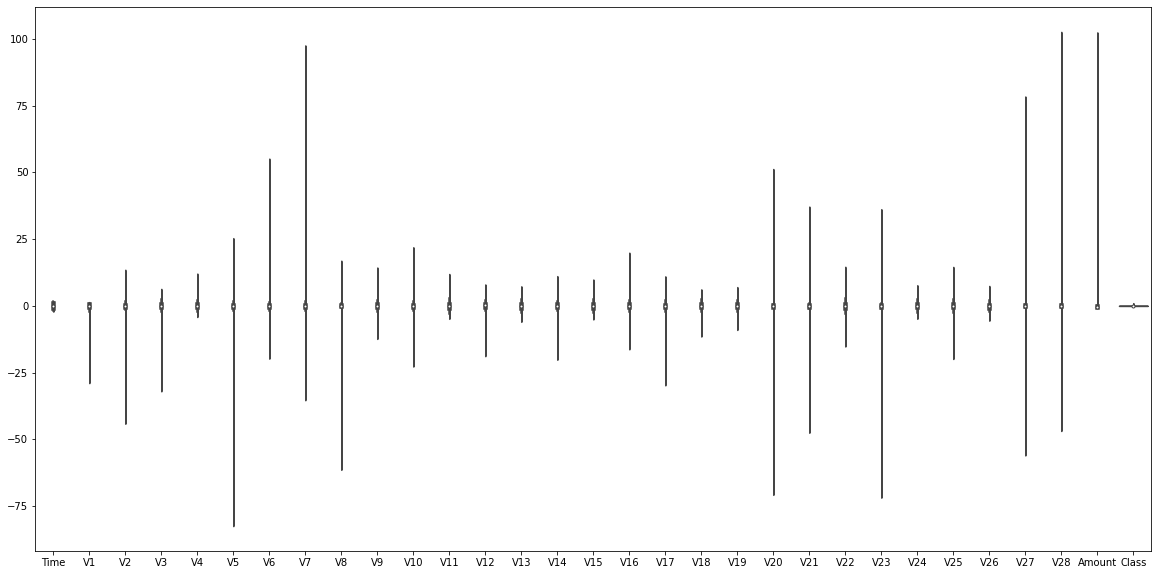

In [ ]:
_, ax = plt.subplots(figsize=(20,10))
sns.violinplot(data = data_normalized, ax = ax)

## Dataset division - Train-validation split

Shuffle the data using the np.random.shuffle function and split the data as follows:

- put 70% in the training dataset
- put 30% in the validation dataset

In [ ]:
# define parameter : test_set / training_set
fraction_validation = 0.3 # 30% of test set and 70% of training set

# parse to numpy
data_normalized_np = data_normalized.to_numpy()

# shuffle data
np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(data_normalized_np) 

# divide into training_set and test_set
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))

train_set = data_normalized_np[:num_train,:]
valid_set = data_normalized_np[num_train:,:]

print('train set size     : %d' % train_set.shape[0])
print('validation set size: %d' % valid_set.shape[0])

train set size     : 199364
validation set size: 85443


Visualize the dimensions of the sets 

In [ ]:
print('Dataset: ')
print('Number of fraud transactions     : %d' % sum(dataset["Class"]))
print('Number of non-fraud transactions : %d' % sum(dataset["Class"] == 0))
print('Number of transactions           : %d' % dataset["Class"].shape[0])

print('\nTraining set: ')
print('Number of fraud transactions     : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]  == 0))
print('Number of transactions           : %d' % train_set.shape[0])

print('\nValidation set: ')
print('Number of fraud transactions     : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1] == 0))
print('Number of transactions           : %d' % valid_set.shape[0])

Dataset: 
Number of fraud transactions     : 492
Number of non-fraud transactions : 284315
Number of transactions           : 284807

Training set: 
Number of fraud transactions     : 337
Number of non-fraud transactions : 199027
Number of transactions           : 199364

Validation set: 
Number of fraud transactions     : 155
Number of non-fraud transactions : 85288
Number of transactions           : 85443


## Preprocess data - Random under sampling

The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.


*   Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.
*   Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset.

*This method is valid under the hypothesis that the number of the no-fraud transaction is more than a hundred times the number of fraud ones*


In [ ]:
# this function is used to create the training and test sets for the ANN

def RUS_array(ratio,train_set):
  '''It returns an array obtained by merging two arrays, one containing the fraud training set and the
  other containing the non-fraud training set.
  The ratio parameter defines the ratio fraud/non-fraud.
  e.g.: ratio=1 and len(train_fraud)= 100 implies that len(new_train_not_fraud)=100.
  
  @param: ratio It is the ratio between fraud and non-fraud data; it is defined as: ratio:=fraud_set/non-fraud_set.
  @param train_set It is the training set.
  '''
  fraud = train_set[train_set[:,-1] == 1]
  non_fraud = train_set[train_set[:,-1] == 0]

  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(non_fraud) 

  new_non_fraud = non_fraud[:int(fraud.shape[0]*ratio),:]

  new_train_set = np.r_[new_non_fraud,fraud]
  np.random.shuffle(new_train_set) 

  # concatenate the two matrix
  return new_train_set

In [ ]:
def RUS(ratio, training_set):
  '''It returns a list obtained by merging two lists, one containing the fraud training set and the
  other containing the non-fraud training set.
  The ratio parameter defines the ratio fraud/non-fraud.
  e.g.: ratio=1 and len(train_fraud)= 100 implies that len(new_train_not_fraud)=100.
  
  @param: ratio It is the ratio between fraud and non-fraud data; it is defined as: ratio:=fraud_set/non-fraud_set.
  @param training_set It is the training set.
  '''
  # initialize the two lists
  train_fraud = list()
  train_not_fraud = list()

  # for each sample in the training set, append it to the proper class
  for sample in training_set:
    if sample[-1] == 1:
      train_fraud.append(sample)
    else:
      train_not_fraud.append(sample)
  
  print('train_fraud len        : ', len(train_fraud))
  print('train_not_fraud len    : ', len(train_not_fraud))
  
  # compute new length of train_not_fraud
  new_length_train_not_fraud = int(len(train_fraud) / ratio)
  print('new train_not_fraud len: ', new_length_train_not_fraud)

  # shuffle train_not_fraud
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_not_fraud)

  # take the first new_length_train_not_fraud elements from train_not_fraud
  train_not_fraud_reduced = train_not_fraud[0:new_length_train_not_fraud]

  # create a unique list for the training set
  train_fraud.extend(train_not_fraud_reduced)

  # shuffle the result set
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_fraud)

  print('new training set len   : ', len(train_fraud))
  print('\n')

  # return the whole new training set
  return train_fraud

In [ ]:
# define parameters -> inside the training_set: fraud / non-fraud
ratio1 = 1 # 50:50
ratio2 = 34/66 # 34:66
ratio3 = 1/3 # 25:75

Apply random under sampling to the training set --> obtain lists 

In [ ]:
training_set1 = RUS(ratio1, train_set)
training_set2 = RUS(ratio2, train_set)
training_set3 = RUS(ratio3, train_set)

train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  337
new training set len   :  674


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  654
new training set len   :  991


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  1011
new training set len   :  1348




Apply RUD and obtain arrays 

In [ ]:
# necessary below for the ANN
train_set1 = RUS_array(ratio1,train_set)
train_set2 = RUS_array(ratio2,train_set)
train_set3 = RUS_array(ratio3,train_set)

### Accuracy 
Defined as the ratio of the total number of predicted transactions that are correct

In [ ]:
def accuracy(TP,TN,FP,FN):
  return ((TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) != 0 else 0)

### Sensitivity 

The proportion of positive observed values correctly predicted as positive. It is also called as True Positive Rate (TPR) or Recall

In [ ]:
def sensitivity(TP,FN):
  return (TP/(TP+FN) if ((TP+FN)) !=0 else 0)

### Specificity 
Defined as, with how much accuracy the negative (legitimate) cases are classified and, in our case, it gives the accuracy on prediction of legitimate transactions classification. It is also called as True Negative Rate (TNR)

In [ ]:
def specificity(TN,FP):
  return (TN/(FP+TN) if (FP+TN)!=0 else 0)

### Precision 
The proportion of positive (fraud) predictions that are actually correct 

In [ ]:
def precision(TP,FP):
  return (TP/(TP+FP) if (TP+FP)!=0 else 0)

### F-measure 
It gives the accuracy of the test which means that it gives the accuracy of experiments performed. It uses the both precision and recall to compute its value. The best value for f1 score is considered at value 1

In [ ]:
def F_measure(precision,sensitivity):
  return ((2 * ((precision * sensitivity)/(precision + sensitivity))) if (precision + sensitivity) !=0 else 0)

### Area under curve (AUC) 

It represents degree or measure of separability that is how much model is capable of differentiating between the classes

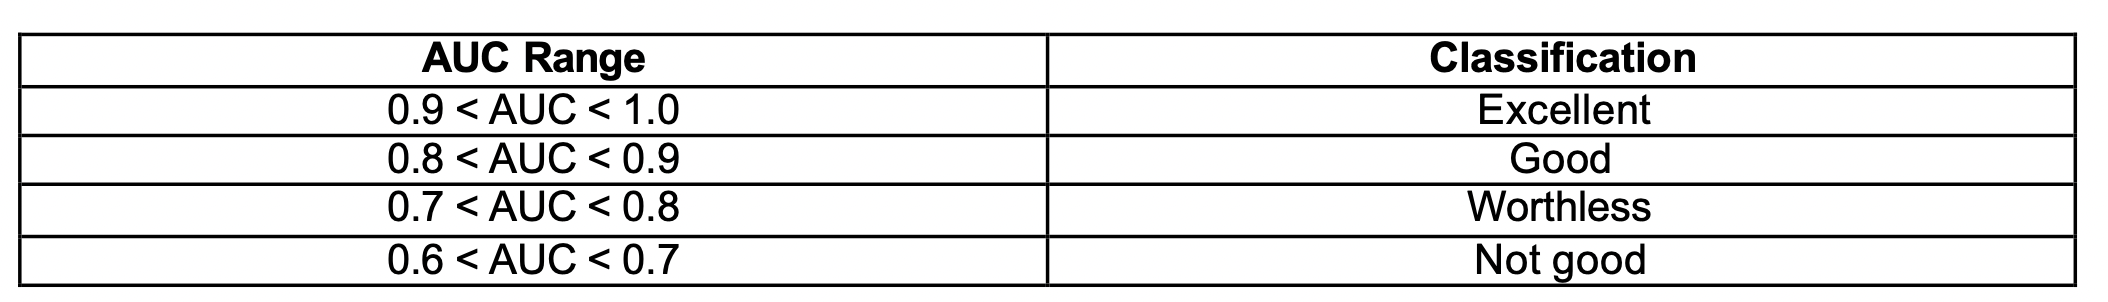

In [ ]:
def AUC(sensitivity, specificity):
  return (0.5 * (sensitivity + specificity))

## Neural Network

### Data Division

Store the data in a matrix and the labels (0 - 1) in a vector

In [ ]:
labels_train1 = train_set1[:,30]
x_data1 = train_set1[:,:30].transpose() 

labels_train1.shape, x_data1.shape

((674,), (30, 674))

In [ ]:
labels_train2 = train_set2[:,30]
x_data2 = train_set2[:,:30].transpose() 

labels_train2.shape, x_data2.shape

((510,), (30, 510))

In [ ]:
labels_train3 = train_set3[:,30]
x_data3 = train_set3[:,:30].transpose() 

labels_train3.shape, x_data3.shape

((449,), (30, 449))

In [ ]:
labels_valid = valid_set[:,30]
x_data_valid = valid_set[:,:30].transpose() 

labels_valid.shape, x_data_valid.shape

((85443,), (30, 85443))

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise

In [ ]:
y_data1 = np.zeros((2, labels_train1.shape[0]))
for i in range(2):
  y_data1[i, labels_train1==i] = 1

In [ ]:
y_data2 = np.zeros((2, labels_train2.shape[0]))
for i in range(2):
  y_data2[i, labels_train2==i] = 1

In [ ]:
y_data3 = np.zeros((2, labels_train3.shape[0]))
for i in range(2):
  y_data3[i, labels_train3==i] = 1

In [ ]:
y_data_valid = np.zeros((2, labels_valid.shape[0]))
for i in range(2):
  y_data_valid[i, labels_valid==i] = 1

Check that the matrix has exactly one element "1" in each column.

In [ ]:
row_sums = np.sum(y_data1, axis = 0)
row_sums.min(), row_sums.max()

(1.0, 1.0)

In [ ]:
y_data1.shape, y_data2.shape, y_data3.shape

((2, 674), (2, 510), (2, 449))

### ANN training


Initialize the parameters with Xavier Uniform initialization 

In [ ]:
def initialize_params_ann(layers_size):
  np.random.seed(0)
  params = list()
  for i in range(len(layers_size) - 1):
    params.append(np.random.uniform(- np.sqrt(6 / (layers_size[i] + layers_size[i+1])), np.sqrt(6 / (layers_size[i] + layers_size[i+1])) ,(layers_size[i+1], layers_size[i])))
    params.append(np.zeros((layers_size[i+1],1)))
  return params

Implement a feedforward ANN with tanh activation function.

To the last layer of the ANN, we apply a *soft-max* layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as
$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.

In [ ]:
def ANN(x, params):
  """
  It calculates the predictions
  """
  W = params[0::2]
  b = params[1::2]
  layer = x 
  for i in range(len(W)):
    layer = W[i] @ layer - b[i]
    if i < len(W) - 1:
      layer = jnp.tanh(layer)
  layer_exp = jnp.exp(layer)
  return layer_exp / jnp.sum(layer_exp, axis = 0)

In [ ]:
def cross_entropy(x, y, params):
  """
  It calculates the cross entropy that is the loss function of the neural network 
  """
  y_appr = ANN(x, params)
  return - jnp.mean(jnp.sum(y*jnp.log(y_appr), axis=0))

In [ ]:
def evaluations(x, y, params):
  """
  It allows to calculate correctenss of predictions 
  """

  digit_appr = jnp.argmax(ANN(x, params), axis = 0)
  digit      = jnp.argmax(y, axis = 0)
  
  TP = jnp.sum(digit_appr * digit )
  TN = jnp.sum((1- digit_appr)* (1-digit ))
  FP = jnp.sum((1 - digit) * (digit_appr))
  FN = jnp.sum((digit ) * (1- digit_appr))

  return [TP,TN,FP,FN]

In [ ]:
layers_size = [30, 20, 10, 2]
params = initialize_params_ann(layers_size)

print('intial cross-entropy: %f' % cross_entropy(x_data_valid, y_data_valid, params))

X entropy: 0.770278


The ANN will be trained with three hidden layers with 20, 10 neurons each.

Use 1000 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.0005$. 

Use minibatches with batch size of 100 and the cross-entropy loss to drive the training.

In [ ]:
def training_loop(x_train,y_train):

  # Training options
  num_epochs = 1000
  batch_size = 100
  learning_rate = 5e-4
  decay_rate = 0.9
  delta = 1e-7
  layers_size = [30, 20, 10, 2]

  history_train_Xen = list()

  grad_jit = jax.jit(jax.grad(cross_entropy, argnums = 2))
  loss_Xen_jit = jax.jit(cross_entropy)

  # Initialize params 
  params = initialize_params_ann(layers_size)

  history_train_Xen.append(loss_Xen_jit(x_train, y_train, params))
  cumulate_grad = [0.0 for i in range(len(params))]

  t0 = time.time()
  for epoch in tqdm(range(num_epochs)):

    # generate 'batch_size' ranodom index for creating the mini batch
    idxs = np.random.choice(x_train.shape[1], batch_size)

    # calculate the gradients
    gradients = grad_jit(x_train[:,idxs], y_train[:,idxs], params)
    for i in range(len(params)):

      # calculate cumulative gradients
      cumulate_grad[i] = decay_rate*cumulate_grad[i] + (1 - decay_rate) * gradients[i]**2
      #updates params
      params[i] -= learning_rate / (delta + jnp.sqrt(cumulate_grad[i])) * gradients[i]
    
      #params[i] -= learning_rate * gradients[i]
    history_train_Xen.append(loss_Xen_jit(x_train, y_train, params))

  print('train loss: %1.3e' % history_train_Xen[-1])
  plt.loglog(history_train_Xen, label = 'train loss')
  return params

### ANN test

  0%|          | 0/1000 [00:00<?, ?it/s]

train loss: 5.337e-02


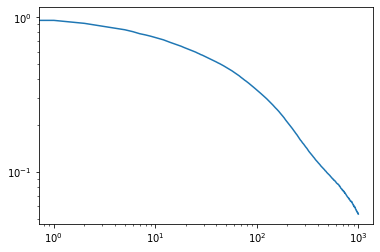

In [ ]:
params1 = training_loop(x_data1,y_data1)

In [ ]:
# evaluate correctness of the predictions 

predictionsNN1 = evaluations(x_data_valid, y_data_valid, params1)

In [ ]:
# calculate and print common metrics

acc = accuracy(predictionsNN1[0],predictionsNN1[1],predictionsNN1[2],predictionsNN1[3]),
sens = sensitivity(predictionsNN1[0], predictionsNN1[3]),
spec = specificity(predictionsNN1[1], predictionsNN1[2]),
prec = precision(predictionsNN1[0], predictionsNN1[2])
f_me = F_measure(prec,sens[0])
auc = AUC(sens[0],spec[0])
  
print('cross-entropy %f' % cross_entropy(x_data_valid, y_data_valid, params1))
print('Accuracy      ' + '{:.1%}'.format(acc[0]))
print('Sensitivity   ' + '{:.1%}'.format(sens[0]))
print('Specificity   ' + '{:.1%}'.format(spec[0]))
print('Precision     ' + '{:.1%}'.format(prec))
print('F_measure     ' + '{:.1%}'.format(f_me))
print('AUC           ' + '{:.1%}'.format(auc))

cross-entropy 0.164763
Accuracy      94.4%
Sensitivity   93.5%
Specificity   94.4%
Precision     2.9%
F_measure     5.7%
AUC           94.0%


  0%|          | 0/1000 [00:00<?, ?it/s]

train loss: 4.580e-02


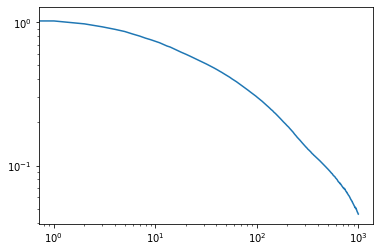

In [ ]:
params2 = training_loop(x_data2,y_data2)

In [ ]:
predictionsNN2= evaluations(x_data_valid, y_data_valid, params2)

In [ ]:
acc = accuracy(predictionsNN2[0],predictionsNN2[1],predictionsNN2[2],predictionsNN2[3]),
sens = sensitivity(predictionsNN2[0], predictionsNN2[3]),
spec = specificity(predictionsNN2[1], predictionsNN2[2]),
prec = precision(predictionsNN2[0], predictionsNN2[2])
f_me = F_measure(prec,sens[0])
auc = AUC(sens[0],spec[0])

print('cross-entropy %f' % cross_entropy(x_data_valid, y_data_valid, params2))  
print('Accuracy      ' + '{:.1%}'.format(acc[0]))
print('Sensitivity   ' + '{:.1%}'.format(sens[0]))
print('Specificity   ' + '{:.1%}'.format(spec[0]))
print('Precision     ' + '{:.1%}'.format(prec))
print('F_measure     ' + '{:.1%}'.format(f_me))
print('AUC           ' + '{:.1%}'.format(auc))

cross-entropy 0.307312
Accuracy      89.2%
Sensitivity   93.5%
Specificity   89.2%
Precision     1.6%
F_measure     3.1%
AUC           91.4%


  0%|          | 0/1000 [00:00<?, ?it/s]

train loss: 3.045e-02


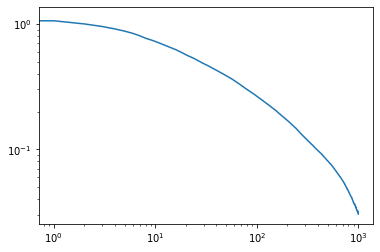

In [ ]:
params3 = training_loop(x_data3,y_data3)

In [ ]:
predictionsNN3 = evaluations(x_data_valid, y_data_valid, params3)

In [ ]:
acc = accuracy(predictionsNN3[0],predictionsNN3[1],predictionsNN3[2],predictionsNN3[3]),
sens = sensitivity(predictionsNN3[0], predictionsNN3[3]),
spec = specificity(predictionsNN3[1], predictionsNN3[2]),
prec = precision(predictionsNN3[0], predictionsNN3[2])
f_me = F_measure(prec,sens[0])
auc = AUC(sens[0],spec[0])

print('cross-entropy %f' % cross_entropy(x_data_valid, y_data_valid, params3))
print('Accuracy      ' + '{:.1%}'.format(acc[0]))
print('Sensitivity   ' + '{:.1%}'.format(sens[0]))
print('Specificity   ' + '{:.1%}'.format(spec[0]))
print('Precision     ' + '{:.1%}'.format(prec))
print('F_measure     ' + '{:.1%}'.format(f_me))
print('AUC           ' + '{:.1%}'.format(auc))

cross-entropy 0.350104
Accuracy      88.0%
Sensitivity   93.5%
Specificity   88.0%
Precision     1.4%
F_measure     2.8%
AUC           90.8%
